Scratch Jupyter Noteboook

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import tqdm  
%matplotlib inline

In [3]:
# Generate 100 random samples in the unit hypersphere (start with 2d)
    # this gives us 100 neurons with "preferred directions" 
# define nonlinear function 
# plot random samples

# given random samples, pass through e1 = [1, 0], and e2[0, 1] to get x and y values respectively of output.  
    # by pass through a vector x we mean 
        # 1 dot product x with each neuron's weight vector (preferred direction)
        # 2 apply nonlinear transformation, to the resulting scalar value. 
        # this gives us a 100 x 2 vector of outputs where we can see the transformation that occurs. 
        
    # do this NUM_LAYERS times and observe the results
    
    
    # now do this in the chaotic regime r ~> 3.59 

Text(0.5, 1.0, "Randomly Sampled Neuron 'Preferred Directions' along the Unit Hypersphere (d=2)")

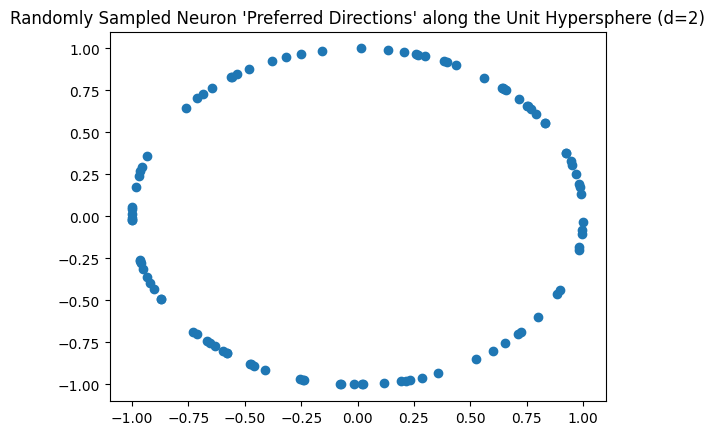

In [4]:
neurons = np.random.normal(loc=0, scale=1, size=(2,100))
neurons = neurons / np.linalg.norm(neurons, axis=0)
plt.scatter(neurons[0,:], neurons[1,:])
plt.title("Randomly Sampled Neuron 'Preferred Directions' along the Unit Hypersphere (d=2)")

In [56]:
def logi(x: float | np.ndarray, r: float) ->  float | np.ndarray :
    return r * x * (1 - x)

def gauss(x: float | np.ndarray, alpha: float, beta: float) -> float | np.ndarray:
    return np.exp(- alpha * np.square(x)) + beta

def forward_pass(neurons: np.ndarray, vector: np.ndarray, step_count: int, params: dict) -> np.ndarray:
    if not  neurons.shape[0] == len(vector):
        raise ValueError(f"Could not dot vector with shape {vector.shape} against neurons with shape(s) {neurons.shape}")
    
    dot_prods = vector @ neurons
    if step_count == 0:
        return dot_prods
    else:    
        # transformed = logi(dot_prods, r=r)
        transformed = gauss(dot_prods, alpha=params['alpha'], beta=params['beta'])
        for step in range(1, step_count):
            # transformed = logi(transformed, r=r)
            transformed = gauss(transformed, alpha=params['alpha'], beta=params['beta'])
        return transformed 

In [57]:
neurons[:,1]
np.sign(neurons)

array([[-1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1., -1.,
         1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,
         1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,
        -1.,  1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1., -1., -1.,
         1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1.,
        -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1.,
        -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,
        -1., -1., -1.,  1.,  1., -1., -1., -1., -1.],
       [-1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1., -1., -1.,
        -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
        -1., -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1.,
         1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1., -1.,
        -1., -1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
         1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1

/tmp/ipykernel_754/77712114.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('inferno', num_passes+1)
/tmp/ipykernel_754/77712114.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(out_1x, out_1y, label=f"Pass {j+1}", c=colors(j+1))


(-1.25, 1.25)

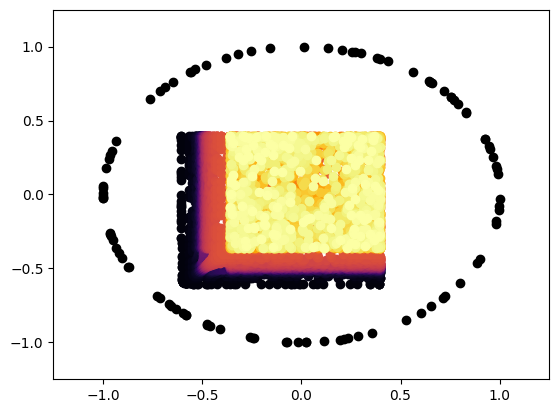

In [58]:
e1 = np.array([1, 0])
e2 = np.array([0, 1])

num_passes = 100
params = {
    'alpha': 9,
    'beta':  -.6045,
    'r': 3.8,
}
colors = cm.get_cmap('inferno', num_passes+1)

plt.scatter(neurons[0,:], neurons[1,:], color="black")
for j in range(1,num_passes): 
    out_1x = forward_pass(neurons, e1, step_count=j, params=params)
    out_1y = forward_pass(neurons, e2, step_count=j, params=params)

    # out_2x = forward_pass(neurons, -e1, step_count=j, r=r)
    # out_2y = forward_pass(neurons, e2, step_count=j, r=r)

    # out_3x = forward_pass(neurons, -e1, step_count=j, r=r)
    # out_3y = forward_pass(neurons, -e2, step_count=j, r=r)

    # out_4x = forward_pass(neurons, e1, step_count=j, r=r)
    # out_4y = forward_pass(neurons, -e2, step_count=j, r=r)

    plt.scatter(out_1x, out_1y, label=f"Pass {j+1}", c=colors(j+1))
    # plt.scatter(out_2x, out_2y, label=f"Pass {j+1}", c=colors(j+1))
    # plt.scatter(out_3x, out_3y, label=f"Pass {j+1}", c=colors(j+1))
    # plt.scatter(out_4x, out_4y, label=f"Pass {j+1}", c=colors(j+1))
    
plt.xlim([-1.25, 1.25])
plt.ylim([-1.25, 1.25])
# plt.legend()

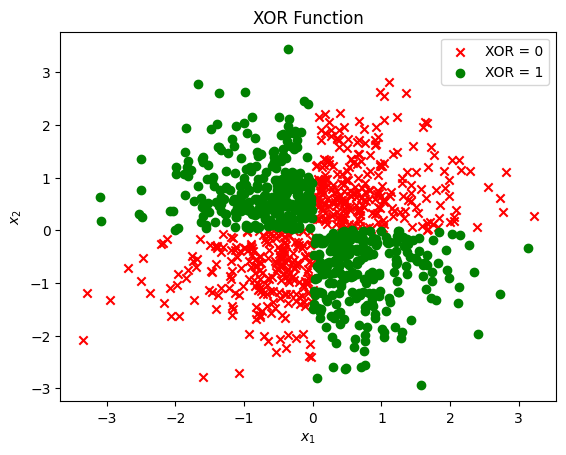

In [41]:
# now to do function approximation with this network 
# determine function 
# pass funcitn throuh layters to get nonlinear transformations, this is bases
# linregression of nonlinear basis values int function estimation 
#


def xor(x: np.ndarray) -> int:

    if x[0] >= 0:
        # First or Fourth Quadrants
        if x[1] >= 0:
            # First Quadrant
                return 0
            # Fourth Quadrant
        else:
            return 1
        
    # Second or Third Quadrants
    else:
        # Second Quadrant
        if x[1] >= 0:
            return 1
        
        # Fourth Quadrant
        else:
            return 0
samples = np.random.normal(loc=0, scale=1, size=(2, 1000))
xors = np.array([xor(samples[:, i]) for i in range(samples.shape[1])])
mask_0 = xors == 0
mask_1 = xors == 1
plt.scatter(samples[0,mask_0], samples[1,mask_0], c='red', marker='x', label='XOR = 0')
plt.scatter(samples[0,mask_1], samples[1,mask_1], c='green', marker='o', label='XOR = 1')
plt.title("XOR Function")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

    

In [ ]:
X = np.zeros((num_passes, neurons.shape[1], len(xors)))
Y = xors
X.shape, Y.shape

for i in tqdm.tqdm(range(len(xors)) ):
    for j in range(num_passes):
        X[j, :, i] = forward_pass(neurons, vector=samples[:,i], step_count=j, params=params)


100%|██████████| 1000/1000 [00:12<00:00, 80.33it/s]


In [80]:
X = X.reshape((num_passes*neurons.shape[1], len(xors)))

In [83]:
# want to solve AX = Y 
A = np.linalg.pinv(X).T @ Y

In [ ]:
def infer(vec, neurons, A, params):
    activations = np.zeros((num_passes, neurons.shape[1])) 
    for j in range(num_passes):
        activations[j, :] = forward_pass(neurons=neurons, vector=vec, step_count=j, params=params)
        
    return A @ activations.flatten()
  
xors_recovered = np.array([
    infer(samples[:, i], neurons, A, params)
    for i in range(samples.shape[1])])  
#  
# 

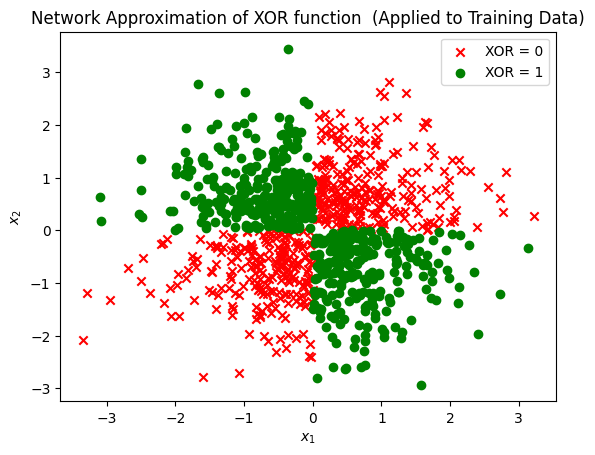

In [90]:


mask_0 = xors_recovered <= .5
mask_1 = xors_recovered > .5
plt.scatter(samples[0,mask_0], samples[1,mask_0], c='red', marker='x', label='XOR = 0')
plt.scatter(samples[0,mask_1], samples[1,mask_1], c='green', marker='o', label='XOR = 1')
plt.title("Network Approximation of XOR function  (Applied to Training Data)")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

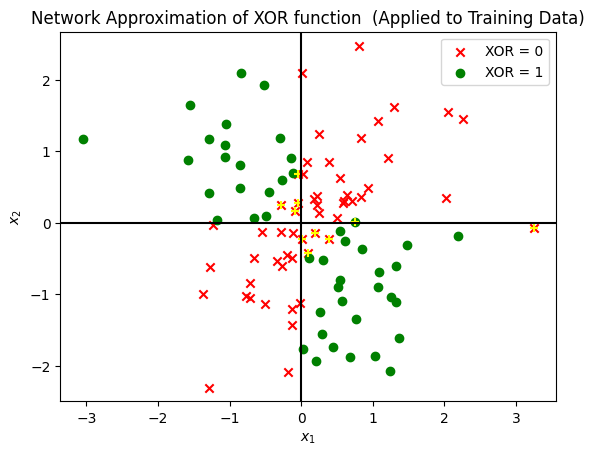

In [100]:
new_samples = np.random.normal(loc=0, scale=1, size=(2, 100))
xors_test = np.array([
    infer(new_samples[:, i], neurons, A, params)
    for i in range(new_samples.shape[1])]
)

mask_test_0 = xors_test <= .5
mask_test_1 = xors_test > .5
plt.scatter(new_samples[0,mask_test_0], new_samples[1,mask_test_0], c='red', marker='x', label='XOR = 0')
plt.scatter(new_samples[0,mask_test_1], new_samples[1,mask_test_1], c='green', marker='o', label='XOR = 1')
plt.title("Network Approximation of XOR function  (Applied to Training Data)")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
    
    
xors_test_rounded = xors_test.copy()
xors_test_rounded[xors_test_rounded <= .5] = 0
xors_test_rounded[xors_test_rounded > .5] = 1
xor_test_actual = np.array([xor(new_samples[:, i]) for i in range(new_samples.shape[1])])

for i in range(new_samples.shape[1]):
    if xors_test_rounded[i] != xor_test_actual[i]:
        plt.scatter(new_samples[0,i], new_samples[1,i], marker='+',c='yellow')
plt.axis('equal')
plt.axvline(x=0, c='black')
plt.axhline(y=0, c='black')